In [1]:
"""
author: Yang
time: 2021.1.27
"""

from random import shuffle
import sndhdr
from turtle import shape
from numpy import dtype
import tensorflow as tf
from utils import *
from sklearn.model_selection import KFold
gpus = tf.config.experimental.list_physical_devices('GPU')
tf.config.experimental.set_visible_devices(gpus[0], 'GPU')
#strategy = tf.distribute.MirroredStrategy(devices=["/gpu:0", "/gpu:1"], cross_device_ops=tf.distribute.HierarchicalCopyAllReduce())


In [2]:
data="""1 & 90.00 & 95.00 & 85.00 & 0.804 \\
2 & 91.75 & 98.00 & 85.50 & 0.842 \\
3 & 91.00 & 96.00 & 86.00 & 0.824 \\
4 & 90.25 & 95.50 & 85.00 & 0.809 \\
5 & 90.25 & 93.00 & 87.50 & 0.806 \\
6 & 90.75 & 91.50 & 90.00 & 0.815 \\
7 & 90.00 & 95.50 & 84.50 & 0.805 \\
8 & 90.75 & 93.00 & 88.50 & 0.816 \\
9 & 89.25 & 94.00 & 84.50 & 0.789 \\
10 & 87.50 & 92.00 & 83.00 & 0.753 \\"""
data_list=data.replace("\\","").replace(" ","").split("\n")

import numpy as np
t=np.zeros(shape=(10,5))

for i in range(10):
    row_data=data_list[i].split("&")
    for j in range(0,5):
        t[i,j]=float(row_data[j])

for i in range(1,4+1):
    print("{:.3f}".format(np.std(t[:,i])),end="&")
    

1.091&1.911&2.006&0.022&

In [3]:
non_train=readTxt("datasets/non_train.txt")
import random
def sequenceDataEnhance(data,num):
    new_data=[]
    for i in range(num):
        str=''
        for j in range(20):
            index=random.randint(0,len(data)-1)
            start=random.randint(0,190)
            str+=data[index][start:start+10]
        new_data.append(str)
    data.extend(new_data)
    return data
def writeTxt(file,content):
    with open(file,'w',encoding="utf-8") as f:
        return f.write(content)

In [5]:
def removeTestSample(_list,beRemoved_list):
    new=[]
    count=0
    for i in range(len(_list)):
        flag=False

        for j in range(len(beRemoved_list)):
            if beRemoved_list[j]==_list[i]:
                flag=True
                count+=1
                break
        if flag==False:
            # if len(_list[i])!=200:
            #     print(_list[i])
            #     print("错误",len(_list[i]))
            new.append(_list[i])
    return new

def readTxt(file):
    with open(file,'r',encoding="utf-8") as f:
        return f.read().split("\n")

dic={'A':'A','T':'T','G':'G','C':'C'}
dic_con={'A':1,'T':2,'G':3,'C':4}
def threeSequecneCnn(text):
    t_list=[]
    for i in range(len(text)-1):
        t_list.append(text[i:i+2])
    return toArray(t_list) 

def readTxt(file):
    with open(file,'r',encoding="utf-8") as f:
        return f.read().split("\n")
non_test=readTxt("datasets/non_test.txt")
non_train=readTxt("datasets/non_train.txt")
non_train=sequenceDataEnhance(non_train,2000)
strong_test=readTxt("datasets/strong_test.txt")
strong_train=readTxt("datasets/strong_train.txt")
weak_test=readTxt("datasets/weak_test.txt")
weak_train=readTxt("datasets/weak_train.txt")

def GenerateFromTextToNumpy(label,train):
    train_con=[]
    train_text=[]
    train_y=[]
    for i in train:
        t=threeSequecne(i) # 化为三元组 步长为1
        con_t=[dic_con[key] for key in i]
        train_con.append(np.array(con_t))
        train_text.append(np.array(t))
        train_y.append(np.array([label]))
    train_con=np.array(train_con)
    train_text=np.array(train_text)
    train_y=np.array(train_y)
    return (train_con,train_text,train_y)


non_train_data=GenerateFromTextToNumpy(0,non_train)
strong_train_data=GenerateFromTextToNumpy(1,strong_train)
weak_train_data=GenerateFromTextToNumpy(1,weak_train)

feature_text=np.concatenate((non_train_data[1],strong_train_data[1],weak_train_data[1]))
train_con=np.concatenate((non_train_data[0],strong_train_data[0],weak_train_data[0]))[:,:,np.newaxis]
train_text=feature_text
train_y=np.concatenate((non_train_data[2],strong_train_data[2],weak_train_data[2]))


def GenerateLayerOneTestData():
    non_test_data=GenerateFromTextToNumpy(0,non_test)
    strong_test_data=GenerateFromTextToNumpy(1,strong_test)
    weak_test_data=GenerateFromTextToNumpy(1,weak_test)
    test_x={"con":np.concatenate((non_test_data[0],strong_test_data[0],weak_test_data[0]))[:,:,np.newaxis],"text":np.concatenate((non_test_data[1],strong_test_data[1],weak_test_data[1]))}
    test_y=np.concatenate((non_test_data[2],strong_test_data[2],weak_test_data[2]))
    return test_x,test_y

test_x,test_y=GenerateLayerOneTestData()


In [6]:
po_test=test_x.copy()
po_test["con"]=po_test["con"][200:]
po_test["text"]=po_test["text"][200:]
ne_test=test_x.copy()
ne_test["con"]=ne_test["con"][0:200]
ne_test["text"]=ne_test["text"][0:200]

def evaluate(x,y):
    res=model.predict(x)
    t=np.array(tf.nn.sigmoid(res),dtype="float16")
    co=0
    num=y.shape[0]
    for i in range(num):
        if int(t[i][0]+0.5)==y[i]:
            co+=1
    return co/num

def returnAccuracy():
    import math
    TP=evaluate(po_test,test_y[200:])
    TN=evaluate(ne_test,test_y[0:200])
    FP=1-TN
    FN=1-TP
    SN=TP/(TP+FN)
    SP=TN/(TN+FP)
    ACC=(TP+TN)/(TP+TN+FN+FP)
    MCC=(TP*TN-FP*FN)/math.sqrt((TP+FP)*(TP+FN)*(TN+FP)*(TN+FN))
    text={"ACC":ACC,"SP":SP,"SN":SN,"MCC":MCC}
    return text
    
def returnVAccuracy():
    import math
    TP=evaluate(po_test,test_y[200:])
    TN=evaluate(ne_test,test_y[0:200])
    FP=1-TN
    FN=1-TP
    SN=TP/(TP+FN)
    SP=TN/(TN+FP)
    ACC=(TP+TN)/(TP+TN+FN+FP)
    MCC=(TP*TN-FP*FN)/math.sqrt((TP+FP)*(TP+FN)*(TN+FP)*(TN+FN))
    text={"ACC":ACC,"SP":SP,"SN":SN,"MCC":MCC}
    return text

In [7]:
kf=KFold(n_splits=10,shuffle=True,random_state=5)
t=kf.split(train_text)
index_list=[(i[0],i[1]) for i in t]

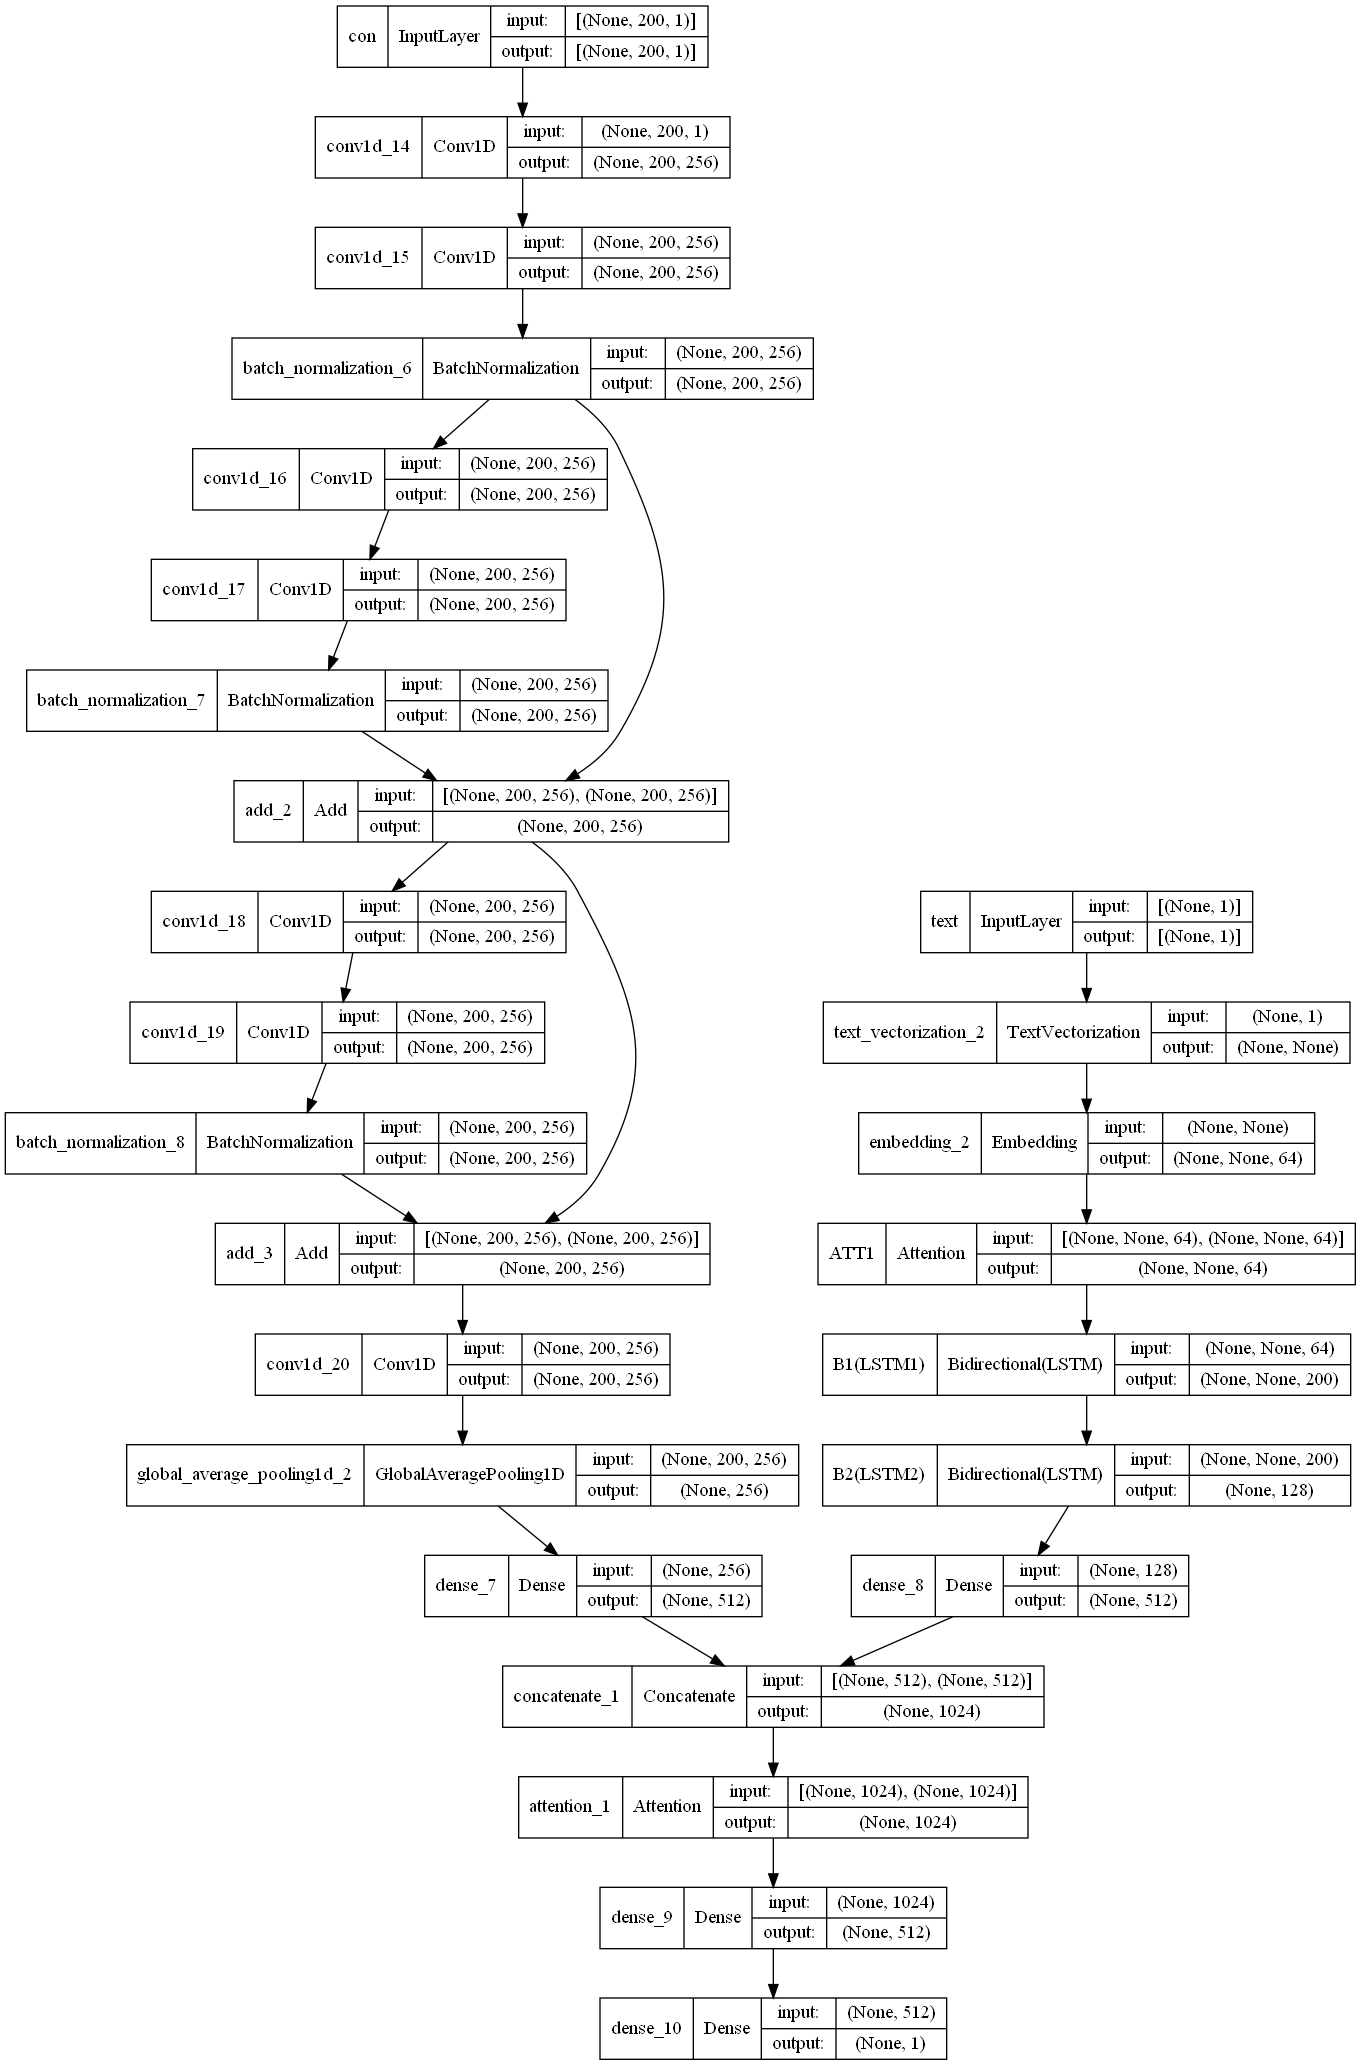

In [10]:
def load_model():
        global encoder
        kernel_num=256
        kernel_size_1=1
        kernel_size_2=2
        kernel_size_3=3
        input_con=tf.keras.Input(shape=(200,1),name='con')
        y=tf.keras.layers.Conv1D(kernel_num,kernel_size=kernel_size_1,strides=1,padding='same', activation=tf.nn.relu,kernel_regularizer=tf.keras.regularizers.l2(0.01))(input_con)
        y=tf.keras.layers.Conv1D(kernel_num, kernel_size=kernel_size_1,strides=1, padding='same', activation=tf.nn.relu,kernel_regularizer=tf.keras.regularizers.l2(0.01))(y)
        
        block1_output=tf.keras.layers.BatchNormalization()(y)

        y=tf.keras.layers.Conv1D(kernel_num, kernel_size=kernel_size_2,strides=1, padding='same', activation=tf.nn.relu,kernel_regularizer=tf.keras.regularizers.l2(0.01))(block1_output)
        y=tf.keras.layers.Conv1D(kernel_num, kernel_size=kernel_size_2,strides=1, padding='same', activation=tf.nn.relu,kernel_regularizer=tf.keras.regularizers.l2(0.01))(y)

        y=tf.keras.layers.BatchNormalization()(y)
        
        block2_output=tf.keras.layers.add([y,block1_output])

        y=tf.keras.layers.Conv1D(kernel_num, kernel_size=kernel_size_3, padding='same', activation=tf.nn.relu,kernel_regularizer=tf.keras.regularizers.l2(0.01))(block2_output)
        y=tf.keras.layers.Conv1D(kernel_num, kernel_size=kernel_size_3, padding='same', activation=tf.nn.relu,kernel_regularizer=tf.keras.regularizers.l2(0.01))(y)
        y=tf.keras.layers.BatchNormalization()(y)
        
        block3_output=tf.keras.layers.add([y,block2_output])

        # y=tf.keras.layers.Conv1D(kernel_num, kernel_size=kernel_size_3, padding='same', activation=tf.nn.relu,kernel_regularizer=tf.keras.regularizers.l2(0.01))(block3_output)
        # y=tf.keras.layers.Conv1D(kernel_num, kernel_size=kernel_size_3, padding='same', activation=tf.nn.relu,kernel_regularizer=tf.keras.regularizers.l2(0.01))(y)
        # y=tf.keras.layers.BatchNormalization()(y)
        
        # block4_output=tf.keras.layers.add([y,block3_output])

        # y=tf.keras.layers.Conv1D(kernel_num, kernel_size=kernel_size_3, padding='same', activation=tf.nn.relu,kernel_regularizer=tf.keras.regularizers.l2(0.01))(block4_output)
        # y=tf.keras.layers.Conv1D(kernel_num, kernel_size=kernel_size_3, padding='same', activation=tf.nn.relu,kernel_regularizer=tf.keras.regularizers.l2(0.01))(y)
        # y=tf.keras.layers.BatchNormalization()(y)
        
        # block5_output=tf.keras.layers.add([y,block4_output])

        y=tf.keras.layers.Conv1D(kernel_num, kernel_size=1, padding='same', activation=tf.nn.relu,kernel_regularizer=tf.keras.regularizers.l2(0.01))(block3_output)

        y=tf.keras.layers.GlobalAveragePooling1D()(y)
        y=tf.keras.layers.Dense(512, activation='relu')(y)    

        input_text=tf.keras.Input(shape=(1,),dtype='string',name="text")
        encoder=tf.keras.layers.TextVectorization(max_tokens=100)
        encoder.adapt(feature_text)
        x=encoder(input_text)

        x=tf.keras.layers.Embedding(input_dim=len(encoder.get_vocabulary()),output_dim=64,mask_zero=True)(x)
        x=tf.keras.layers.Attention(name="ATT1")([x,x])
        x=tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(100,return_sequences=True,name="LSTM1"),name="B1")(x)
        x=tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64,name="LSTM2"),name="B2")(x)
        x=tf.keras.layers.Dense(512, activation='relu')(x)

        feature_layer=tf.keras.layers.concatenate([x,y])
        att=tf.keras.layers.Attention()([feature_layer,feature_layer])
        den=tf.keras.layers.Dense(512, activation='relu')(att)
        output=tf.keras.layers.Dense(1)(den)
        model=tf.keras.Model([input_con,input_text],output)
        base_learning_rate = 0.001
        model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
                loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),metrics=['accuracy'])
        return model
model=load_model()
tf.keras.utils.plot_model(model,show_shapes=True)

In [ ]:
def load_model():
        global encoder
        kernel_num=256
        kernel_size_1=1
        kernel_size_2=2
        kernel_size_3=3
        input_con=tf.keras.Input(shape=(200,1),name='con')
        y=tf.keras.layers.Conv1D(kernel_num,kernel_size=kernel_size_1,strides=1,padding='same', activation=tf.nn.relu,kernel_regularizer=tf.keras.regularizers.l2(0.01))(input_con)
        y=tf.keras.layers.Conv1D(kernel_num, kernel_size=kernel_size_1,strides=1, padding='same', activation=tf.nn.relu,kernel_regularizer=tf.keras.regularizers.l2(0.01))(y)
        y=tf.keras.layers.BatchNormalization()(y)


        y=tf.keras.layers.Conv1D(kernel_num, kernel_size=kernel_size_2,strides=1, padding='same', activation=tf.nn.relu,kernel_regularizer=tf.keras.regularizers.l2(0.01))(y)
        y=tf.keras.layers.Conv1D(kernel_num, kernel_size=kernel_size_2,strides=1, padding='same', activation=tf.nn.relu,kernel_regularizer=tf.keras.regularizers.l2(0.01))(y)

        y=tf.keras.layers.BatchNormalization()(y)
        


        y=tf.keras.layers.Conv1D(kernel_num, kernel_size=kernel_size_3, padding='same', activation=tf.nn.relu,kernel_regularizer=tf.keras.regularizers.l2(0.01))(y)
        y=tf.keras.layers.Conv1D(kernel_num, kernel_size=kernel_size_3, padding='same', activation=tf.nn.relu,kernel_regularizer=tf.keras.regularizers.l2(0.01))(y)
        y=tf.keras.layers.BatchNormalization()(y)
        



        y=tf.keras.layers.Conv1D(kernel_num, kernel_size=1, padding='same', activation=tf.nn.relu,kernel_regularizer=tf.keras.regularizers.l2(0.01))(y)

        y=tf.keras.layers.GlobalAveragePooling1D()(y)
        y=tf.keras.layers.Dense(64, activation='relu')(y)    

        input_text=tf.keras.Input(shape=(1,),dtype='string',name="text")
        encoder=tf.keras.layers.TextVectorization(max_tokens=100)
        encoder.adapt(feature_text)
        x=encoder(input_text)


        x=tf.keras.layers.Embedding(input_dim=len(encoder.get_vocabulary()),output_dim=64,mask_zero=True)(x)
        x=tf.keras.layers.Attention(name="ATT1")([x,x])
        x=tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(100,return_sequences=True,name="LSTM1"),name="B1")(x)
        x=tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64,name="LSTM2"),name="B2")(x)
        x=tf.keras.layers.Dense(512, activation='relu')(x)

        #feature_layer=tf.keras.layers.concatenate([x,y])
        #att=tf.keras.layers.Attention()([feature_layer,feature_layer])
        output=tf.keras.layers.Dense(1)(y)
        model=tf.keras.Model([input_con,input_text],output)
        base_learning_rate = 0.001
        model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
                loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),metrics=['accuracy'])
        return model
model=load_model()
tf.keras.utils.plot_model(model,show_shapes=True)

In [11]:

def train(index):
    callback = tf.keras.callbacks.EarlyStopping(patience=5,monitor='val_loss')

    epochs=120
    TRAIN_ACC=0
    MAX_ACC=0
    min_loss=100
    text={}
    val_acc=0
    for i in range(epochs):
        
        if i<50:
            lr=0.001
        elif i<80:
            lr=0.0005
        else:
            lr=0.0001
            
        def scheduler(epoch):
            # 前5个epoch学习率保持不变，5个epoch后学习率按比例衰减
            return lr
        reduce_lr = tf.keras.callbacks.LearningRateScheduler(scheduler)
        
        print(f"index:{index},epochs:{i}")
        history=model.fit(each_fold_train_x,each_fold_train_y,shuffle=True,epochs=1,batch_size=128,validation_data=(each_fold_val_x,each_fold_val_y),callbacks=[reduce_lr])
        if history.history["val_loss"][0]<=min_loss:
            try:
                min_loss=history.history["val_loss"][0]
                text=returnAccuracy()
                text["val_acc"]=history.history["val_accuracy"][0]
                # if text["SP"]>0.94 and text["ACC"]>0.86:
                #     global flag
                #     flag=True
                #     break

            except:
                pass
        print(text,val_acc)
    record.append(text) 

In [ ]:
record=[]
flag=False
model=None
for i in range(10):
    fold_order=i
    (train_index,val_index)=index_list[fold_order]
    each_fold_train_x={"con":train_con[train_index],"text":train_text[train_index]}
    each_fold_train_y=train_y[train_index]
    each_fold_val_x={"con":train_con[val_index],"text":train_text[val_index]}
    each_fold_val_y=train_y[val_index]
    model=load_model()
    train(i)
    if flag:
        break
print(record)

In [43]:
record=[]
flag=False
model=None
for i in range(10):
    (train_index,val_index)=index_list[fold_order]
    each_fold_train_x={"con":train_con[train_index],"text":train_text[train_index]}
    each_fold_train_y=train_y[train_index]
    each_fold_val_x={"con":train_con[val_index],"text":train_text[val_index]}
    each_fold_val_y=train_y[val_index]
    model=load_model()
    train(i)
    break
print(record)

index:0,epochs:0
21/21 [==============================] - 2s 54ms/step - loss: 12.1229 - accuracy: 0.7001 - val_loss: 8.5863 - val_accuracy: 0.4815 - lr: 0.0010
{} 0
index:0,epochs:1
21/21 [==============================] - 1s 45ms/step - loss: 6.1756 - accuracy: 0.7480 - val_loss: 4.3932 - val_accuracy: 0.4815 - lr: 0.0010
{} 0
index:0,epochs:2
21/21 [==============================] - 1s 45ms/step - loss: 3.1555 - accuracy: 0.7507 - val_loss: 2.4228 - val_accuracy: 0.4815 - lr: 0.0010
{'ACC': 0.51, 'SP': 0.025, 'SN': 0.995, 'MCC': 0.08226900697897269, 'val_acc': 0.48148149251937866} 0
index:0,epochs:3
21/21 [==============================] - 1s 45ms/step - loss: 1.7518 - accuracy: 0.7469 - val_loss: 1.5064 - val_accuracy: 0.4815 - lr: 0.0010
{'ACC': 0.51, 'SP': 0.025, 'SN': 0.995, 'MCC': 0.08226900697897269, 'val_acc': 0.48148149251937866} 0
index:0,epochs:4
21/21 [==============================] - 1s 45ms/step - loss: 1.0949 - accuracy: 0.7364 - val_loss: 1.0807 - val_accuracy: 0.481

KeyboardInterrupt: 

In [19]:
ACC=0
SP=0
SN=0
MCC=0
VAL_ACC=0
for i in record:
    ACC+=i["ACC"]
    SP+=i["SP"]
    SN+=i["SN"]
    MCC+=i["MCC"]
    VAL_ACC+=i["val_acc"]
ACC/=10
SP/=10
SN/=10
MCC/=10
VAL_ACC/=10
text={"ACC":ACC,"SP":SP,"SN":SN,"MCC":MCC,"VAL_ACC":VAL_ACC}
print(text)

{'ACC': 0.0, 'SP': 0.0, 'SN': 0.0, 'MCC': 0.0, 'VAL_ACC': 0.0}


In [55]:
res=model.predict(po_test)

In [58]:
np.save("enhence.npy",res)

In [98]:
model.load_weights("1.weight")

In [42]:
count=0
for i in tf.nn.sigmoid(res):
    print(i)
    if i<=0.5:
        count+=1
count

tf.Tensor([0.10254695], shape=(1,), dtype=float32)
tf.Tensor([0.11912607], shape=(1,), dtype=float32)
tf.Tensor([0.6421603], shape=(1,), dtype=float32)
tf.Tensor([0.12964807], shape=(1,), dtype=float32)
tf.Tensor([0.10643795], shape=(1,), dtype=float32)
tf.Tensor([0.24708183], shape=(1,), dtype=float32)
tf.Tensor([0.49129996], shape=(1,), dtype=float32)
tf.Tensor([0.10652558], shape=(1,), dtype=float32)
tf.Tensor([0.26054588], shape=(1,), dtype=float32)
tf.Tensor([0.10410438], shape=(1,), dtype=float32)
tf.Tensor([0.7092725], shape=(1,), dtype=float32)
tf.Tensor([0.18235914], shape=(1,), dtype=float32)
tf.Tensor([0.11121471], shape=(1,), dtype=float32)
tf.Tensor([0.17930986], shape=(1,), dtype=float32)
tf.Tensor([0.10336066], shape=(1,), dtype=float32)
tf.Tensor([0.24511828], shape=(1,), dtype=float32)
tf.Tensor([0.10814514], shape=(1,), dtype=float32)
tf.Tensor([0.10283693], shape=(1,), dtype=float32)
tf.Tensor([0.10125918], shape=(1,), dtype=float32)
tf.Tensor([0.10118924], shape=(1,

182

In [56]:
tf.nn.sigmoid(res)

<tf.Tensor: shape=(200, 1), dtype=float32, numpy=
array([[0.1104247 ],
       [0.12510717],
       [0.48932204],
       [0.17354451],
       [0.11973321],
       [0.2236381 ],
       [0.37532076],
       [0.11375241],
       [0.14039803],
       [0.11095908],
       [0.55939543],
       [0.1709413 ],
       [0.11609669],
       [0.13374296],
       [0.11301476],
       [0.14221896],
       [0.11425184],
       [0.10992536],
       [0.10863678],
       [0.10962058],
       [0.12450477],
       [0.10882854],
       [0.10887939],
       [0.11269807],
       [0.46538007],
       [0.10922015],
       [0.45314425],
       [0.11186803],
       [0.24909337],
       [0.32854837],
       [0.12099449],
       [0.10935272],
       [0.09891677],
       [0.08668936],
       [0.07766898],
       [0.08736025],
       [0.08808136],
       [0.34700853],
       [0.08813769],
       [0.08922676],
       [0.08295187],
       [0.32386705],
       [0.08323685],
       [0.16706981],
       [0.09269985],
     

In [57]:
np.mean(tf.nn.sigmoid(res))

0.18440637

In [17]:
count=0
for index,i in enumerate(record):
    try:
        ACC="{:.2f}".format(i['ACC']*100)
        SP="{:.2f}".format(i['SP']*100)
        SN="{:.2f}".format(i['SN']*100)
        MCC="{:.3f}".format(i['MCC'])
        text=f"{index+1} & {ACC} & {SP} & {SN} & {MCC} \\\\"
        print(text)
        count+=1
    except:
        pass
ACC=0
SP=0
SN=0
MCC=0
for i in record:
    try:
        ACC+=i["ACC"]
        SP+=i["SP"]
        SN+=i["SN"]
        MCC+=i["MCC"]
    except:
        pass
ACC/=count
SP/=count
SN/=count
MCC/=count
ACC="{:.2f}".format(ACC*100)
SP="{:.2f}".format(SP*100)
SN="{:.2f}".format(SN*100)
MCC="{:.3f}".format(MCC)
text=f"Mean & {ACC} & {SP} & {SN} & {MCC} \\\\"
print(text)

1 & 90.00 & 95.00 & 85.00 & 0.804 \\
2 & 91.75 & 98.00 & 85.50 & 0.842 \\
3 & 91.00 & 96.00 & 86.00 & 0.824 \\
4 & 90.25 & 95.50 & 85.00 & 0.809 \\
5 & 90.25 & 93.00 & 87.50 & 0.806 \\
6 & 90.75 & 91.50 & 90.00 & 0.815 \\
7 & 90.00 & 95.50 & 84.50 & 0.805 \\
8 & 90.75 & 93.00 & 88.50 & 0.816 \\
9 & 89.25 & 94.00 & 84.50 & 0.789 \\
10 & 87.50 & 92.00 & 83.00 & 0.753 \\
Mean & 90.15 & 94.35 & 85.95 & 0.806 \\
